# BACTERIA

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [3]:
# import packages
import os
import qiime2 as q2
import pandas as pd
import plotnine as p9
import dokdo
import matplotlib.pyplot as plt
from qiime2.plugins import feature_classifier
from qiime2.plugins import feature_table
from qiime2.plugins.taxa.visualizers import barplot
from qiime2.plugins.taxa.methods import filter_table
from qiime2.plugins.taxa.methods import filter_seqs
from qiime2.plugins.metadata.visualizers import tabulate

import sys
sys.path.append(os.path.abspath("./../"))
from utils import *

In [4]:
# # define workdir
# %env WORKDIR /home/nezapa/qiime-thesis
# WORKDIR = os.environ.get("WORKDIR")

In [5]:
# import data
denoisetable = q2.Artifact.load('./results/denoisetable.qza')
rep_seqs = q2.Artifact.load('./results/rep_seqs.qza')
denoising_stats = q2.Artifact.load('./results/denoising_stats.qza')
sample_metadata = q2.Metadata.load('../00.sample-metadata.tsv')

In [6]:
# define asv_table for mapping
asv_table = denoisetable.view(view_type=pd.DataFrame).T

# create mapping index to asv
import json
old_index = asv_table.index.tolist()
asv_values = [f'ASVB{i:03d}' for i in range(len(asv_table))]
asv_mapping = dict(zip(old_index, asv_values))
json.dump(asv_mapping, open('asv_mapping.json', 'w'), indent=4)

In [7]:
# summarise and visualise
feature_table.visualizers.summarize(
    table = denoisetable,
    sample_metadata = sample_metadata
).visualization

<visualization: Visualization uuid: 41964f27-ea88-409a-8872-5ef7580bfcb0>

## TAXONOMIC ANALYSIS

In [8]:
# # load classifier data
# classifier = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/classifier-B-341F_802R.qza')
# reference_reads = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/ref-seqs_341F_802R.qza')
# reference_taxonomy = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/silva-138-99-tax.qza')

In [9]:
# define model choices
models = {
    'sklearn': feature_classifier.methods.classify_sklearn,
    'vsearch': feature_classifier.methods.classify_consensus_vsearch,
    'blast': feature_classifier.methods.classify_consensus_blast,
    'hybrid': feature_classifier.pipelines.classify_hybrid_vsearch_sklearn
}

In [10]:
# choose model, run for each model_name
model_name = "sklearn"
model = models[model_name]

In [11]:
# classify the seqences using different classifiers
# run once for each model
# this step might take some time

if os.path.exists(f'./results/taxonomy_{model_name}.qza'):
    taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')
else:
    if model_name == "sklearn":
        taxonomy = model(
            reads = rep_seqs,
            classifier = classifier,
            n_jobs=4
        )
        
    elif model_name == "vsearch":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            threads = 15
        )
    elif model_name == "blast":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy
            )
    elif model_name == "hybrid":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            classifier = classifier,
            threads = 2,
            prefilter = False
            )
    else:
        print(f"model name {model_name} doesn't exist")
    
    taxonomy = taxonomy.classification
    taxonomy.save(f'./results/taxonomy_{model_name}.qza')

In [12]:
# merge all taxonomy classifications
for idx, model_name in enumerate(models.keys()):
    model_df = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza').view(pd.DataFrame)
    model_df.columns = [f'{col}_{model_name}' for col in model_df.columns]
    if idx == 0:
        res_df = model_df.copy()
    else:
        res_df = res_df.merge(model_df, on = 'Feature ID')

In [13]:
# view merged df as q2 viz, compare different classifiers
res_df_viz = q2.plugins.metadata.visualizers.tabulate(q2.Metadata(res_df)).visualization
res_df_viz.save('./results/res_df_viz.qzv')
res_df_viz

<visualization: Visualization uuid: de9e1a72-8d90-43e8-a9ce-78487aace434>

In [14]:
# choose the best classifier, save as taxonomy
model_name = "sklearn"
taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')

In [15]:
# load classification results of a chosen classifier as metadata and view them
taxonomy_metadata = taxonomy.view(q2.Metadata)  # or pd.DataFrame
q2.plugins.metadata.visualizers.tabulate(taxonomy_metadata).visualization

<visualization: Visualization uuid: abd35833-21f0-435f-8293-bd97fa072beb>

In [16]:
# load rep_seqs as metadata
rep_seqs_mtdt = rep_seqs.view(q2.Metadata)

# merge dataframes in the background (appends new column)
annotated_taxonomy_metadata = taxonomy_metadata.merge(rep_seqs_mtdt)

# visualize merged dataframes as metadata viz
q2.plugins.metadata.visualizers.tabulate(annotated_taxonomy_metadata).visualization

<visualization: Visualization uuid: 117e0796-6a25-474a-ba49-4c976a7a76e3>

### FILTER BY TAXONOMY

In [17]:
# filter denoisetable, keep only d_Bacteria
denoisetable_ba = filter_table(
    table = denoisetable,
    taxonomy = taxonomy, 
    include = 'd__Bacteria'
)
denoisetable_ba.filtered_table.save('./results/denoisetable_ba.qza')

'./results/denoisetable_ba.qza'

In [20]:
# filter rep_seqs, keep only d_Baceria
rep_seqs_ba = filter_seqs(
    sequences = rep_seqs,
    taxonomy = taxonomy,
    include = 'd__Bacteria'
)

rep_seqs_ba.filtered_sequences.save('./results/rep_seqs_ba.qza')

/home/npajek/miniconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/q2_taxa/_method.py:121: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/home/npajek/miniconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/q2_types/feature_data/_transformer.py:254: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


'./results/rep_seqs_ba.qza'

### TAXONOMY CORRECTIONS, TAXA PER SPECIMEN & LaTeX prep

In [22]:
# load denoise as dataframe and transpose (feature id is index), add name to index
denoise_df = denoisetable_ba.filtered_table.view(view_type = pd.DataFrame).T
denoise_df.index.name = 'id'

# load annotated data as df
annotated_df = annotated_taxonomy_metadata.to_dataframe()

# merge the two using indices of both dataframes
merged_df = denoise_df.merge(annotated_df['Taxon'], left_index=True, right_index=True)

# set Taxon column as index and show transposed
taxon_df = merged_df.set_index('Taxon').T

In [23]:
# run once for each sample (subject)
# choose a sample 
subject = 'P19A'
taxon_df.loc[[subject]].T.reset_index().query(f'{subject} > 0.0').value_counts('Taxon')

# define custom_df, get rid of Unassigned
custom_df = taxon_df.loc[[subject]].T.reset_index()
custom_df = custom_df.query(f'Taxon != "Unassigned" and {subject} > 0')

custom_df['Domain'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='d__', null_data='Unassigned'))
custom_df['Phylum'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='p__', null_data='Unassigned'))
custom_df['Class'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='c__', null_data='Unassigned'))
custom_df['Order'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='o__', null_data='Unassigned'))
custom_df['Family'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='f__', null_data='Unassigned'))
custom_df['Genus'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='g__', null_data='Unassigned'))
#custom_df['Species'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='s__'))

invalid_words = ['Unknown_Family', "uncultured", "Unassigned"]
unassigned_like_words = ['Candidatus_Amesbacteria', 'Sva0081_sediment_group', "Marine_Group_II", 'Sva0081_sediment_group', 'Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium', 'Marine_Group_II', 'WD2101_soil_group', 'WWE3', 'CL500-29_marine_group', 'mle1-7', 'OM27_clade', 'MND1', 'Pir4_lineage','CCM11a', 'TRA3-20', 'hgcI_clade', 'BD2-11_terrestrial_group', 'Ellin6067', 'SC-I-84', 'NB1-j', 'OM182_clade', '[Eubacterium]_eligens_group', 'AKYG587','TM7a', 'OM60(NOR5)_clade', 'CCD24', 'vadinHA49', 'RCP2-54', 'SH-PL14', 'bacteriap25', 'ADurb.Bin063-1', 'NS11-12_marine_group', 'Mitochondria', 'SM1A02']
custom_df = custom_df.apply(backtrace_unassigned, unassigned_like_words=unassigned_like_words, invalid_words=invalid_words, axis=1)

custom_df['Taxon'] = custom_df.apply(reassemble_taxon, axis=1)
custom_df = custom_df.apply(remove_duplicates, axis=1)

columns = ['Phylum', 'Class', 'Order', 'Family', 'Genus']#, 'Species']
# columns = ['Order', 'Family', 'Genus', 'Species']
taxa_per_species = custom_df.groupby(columns).sum()
taxa_per_species[subject] /= taxa_per_species[subject].sum()
taxa_per_species[subject] = [f'{x*100:.3f}' for x in taxa_per_species[subject]]

print(taxa_per_species.to_latex(escape=False))

#taxa_per_species

\begin{tabular}{llllll}
\toprule
                  &                  &                    &                 &             &    P19A \\
Phylum & Class & Order & Family & Genus &         \\
\midrule
Actinobacteriota & Acidimicrobiia & Microtrichales & Ilumatobacteraceae & Unclass. Ilumatobacteraceae CL500-29_marine_group &   0.005 \\
Bacteroidota & Bacteroidia & Bacteroidales & Bacteroidaceae & Bacteroides &   0.419 \\
                  &                  &                    & Marinifilaceae & Butyricimonas &   0.003 \\
                  &                  &                    &                 & Odoribacter &   0.016 \\
                  &                  &                    & Tannerellaceae & Parabacteroides &   0.047 \\
                  &                  & Cytophagales & Spirosomaceae & Arcicella &   0.021 \\
                  &                  & Flavobacteriales & Flavobacteriaceae & Flavobacterium &   0.005 \\
                  &                  & Sphingobacteriales & Unclas

/tmp/ipykernel_4237/3469231507.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
/tmp/ipykernel_4237/3469231507.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


### VISUALIZATIONS

In [24]:
# prepare new_taxonomy file with taxonomy corrections, same as above
taxonomy_df = taxonomy.view(pd.DataFrame)

taxonomy_df['Domain'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='d__', null_data='Unassigned')
taxonomy_df['Phylum'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='p__', null_data='Unassigned')
taxonomy_df['Class'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='c__', null_data='Unassigned')
taxonomy_df['Order'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='o__', null_data='Unassigned')
taxonomy_df['Family'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='f__', null_data='Unassigned')
taxonomy_df['Genus'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='g__', null_data='Unassigned')

invalid_words = ['Unknown_Family', "uncultured", "Unassigned"]
unassigned_like_words = ['Sva0081_sediment_group', "Marine_Group_II", 'Sva0081_sediment_group', 'Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium', 'Marine_Group_II', 'WD2101_soil_group', 'WWE3', 'CL500-29_marine_group', 'mle1-7', 'OM27_clade', 'MND1', 'Pir4_lineage','CCM11a', 'TRA3-20', 'hgcI_clade', 'BD2-11_terrestrial_group', 'Ellin6067', 'SC-I-84', 'NB1-j', 'OM182_clade', '[Eubacterium]_eligens_group', 'AKYG587','TM7a', 'OM60(NOR5)_clade', 'CCD24', 'vadinHA49', 'RCP2-54', 'SH-PL14', 'bacteriap25', 'ADurb.Bin063-1', 'NS11-12_marine_group', 'Mitochondria', 'SM1A02', 'Lachnospiraceae_UCG-010']
taxonomy_df = taxonomy_df.apply(backtrace_unassigned, unassigned_like_words=unassigned_like_words, invalid_words=invalid_words, axis=1)

taxonomy_df['Taxon'] = taxonomy_df.apply(reassemble_taxon, axis=1)
taxonomy_df = taxonomy_df.apply(remove_duplicates, axis=1)

new_taxonomy = q2.Artifact.import_data("FeatureData[Taxonomy]", taxonomy_df)

In [25]:
new_taxonomy_df = new_taxonomy.view(view_type = pd.DataFrame)
new_taxonomy_df

,Taxon,Confidence,Domain,Phylum,Class,Order,Family,Genus
Feature ID,,,,,,,,
1eba318014a80c7ef58c4fe5a25317e7,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.7048761204522636,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Burkholderiaceae,Ralstonia
6fb0ae5e8d7e91acc3481ae385563c37,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.9999509990028024,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Burkholderiaceae,Ralstonia
4d4ae718b70724fc25f959b8888ba0c8,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.8440329231396565,Bacteria,Proteobacteria,Gammaproteobacteria,Aeromonadales,Aeromonadaceae,Aeromonas
b2573224b84130faa841a65345bd6686,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,0.7741138968163481,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Spirosomaceae,Arcicella
2d4b6ec0c2f78d209e9f3dea142e80ee,d__Bacteria;p__Planctomycetota;c__Phycisphaera...,0.9454181775172625,Bacteria,Planctomycetota,Phycisphaerae,Tepidisphaerales,Unclass. Tepidisphaerales WD2101_soil_group,Unclass. Tepidisphaerales WD2101_soil_group
...,...,...,...,...,...,...,...,...
d944d372f9e6f181de0b1e03964925b9,d__Unassigned;p__Unassigned;c__Unassigned;o__U...,0.45809593428277495,Unassigned,Unclass. Unassigned,Unclass. Unassigned,Unclass. Unassigned,Unclass. Unassigned,Unclass. Unassigned
06c409a280d0b5017226560ee5b53b94,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.9247622511411105,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Oxalobacteraceae,Massilia
d6e8e226b606c9e3a6a571b0276b623c,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,0.8512655400051062,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Comamonadaceae,Rhodoferax


In [26]:
for col in columns:
    cases = new_taxonomy_df.query(f"not {col}.str.contains('Unclass.')")[col]
    print(f'{col}: {cases.nunique()}')
    print(cases.unique().tolist())
    print('')

Phylum: 18
['Proteobacteria', 'Bacteroidota', 'Planctomycetota', 'Verrucomicrobiota', 'Acidobacteriota', 'Actinobacteriota', 'Fusobacteriota', 'Patescibacteria', 'Nitrospirota', 'Firmicutes', 'Desulfobacterota', 'Myxococcota', 'Spirochaetota', 'Bdellovibrionota', 'Gemmatimonadota', 'Thermoplasmatota', 'Chloroflexi', 'Cyanobacteria']

Class: 29
['Gammaproteobacteria', 'Bacteroidia', 'Phycisphaerae', 'Alphaproteobacteria', 'Verrucomicrobiae', 'Vicinamibacteria', 'Kapabacteria', 'Acidimicrobiia', 'Fusobacteriia', 'Planctomycetes', 'Omnitrophia', 'Saccharimonadia', 'Nitrospiria', 'Actinobacteria', 'Bacilli', 'Clostridia', 'Acidobacteriae', 'Desulfobacteria', 'Polyangia', 'Spirochaetia', 'Bdellovibrionia', 'Desulfuromonadia', 'Negativicutes', 'Gemmatimonadetes', 'Gracilibacteria', 'Thermoplasmata', 'Anaerolineae', 'Cyanobacteriia', 'Microgenomatia']

Order: 59
['Burkholderiales', 'Aeromonadales', 'Cytophagales', 'Tepidisphaerales', 'Sphingomonadales', 'Pseudomonadales', 'Vicinamibacterales'

In [27]:
# visualise classifications in qiime2
taxa_bar_plot = barplot(
    table = denoisetable_ba.filtered_table,
    taxonomy = new_taxonomy,
    metadata = sample_metadata
).visualization

In [28]:
# save taxa_bar_plot in results folder
taxa_bar_plot.save('./results/taxa_bar_plots.qzv')

'./results/taxa_bar_plots.qzv'

In [29]:
# visualise taxa bar plot - interacive taxa bar plot visualisation
taxa_bar_plot

<visualization: Visualization uuid: 7f5c98f3-b1b0-440a-8bac-5d4a4504a3eb>

In [30]:
def label_filter(lbl):
    if lbl.count(';') == 0:
        return lbl
    
    lbl_split = lbl.split(';')
    
    new_label = []
    for piece in lbl_split[::-1]:
        new_label.append(piece)
        if 'uncultured' not in piece and piece != '__':
            break
            
    return ';'.join(new_label[::-1][:2])

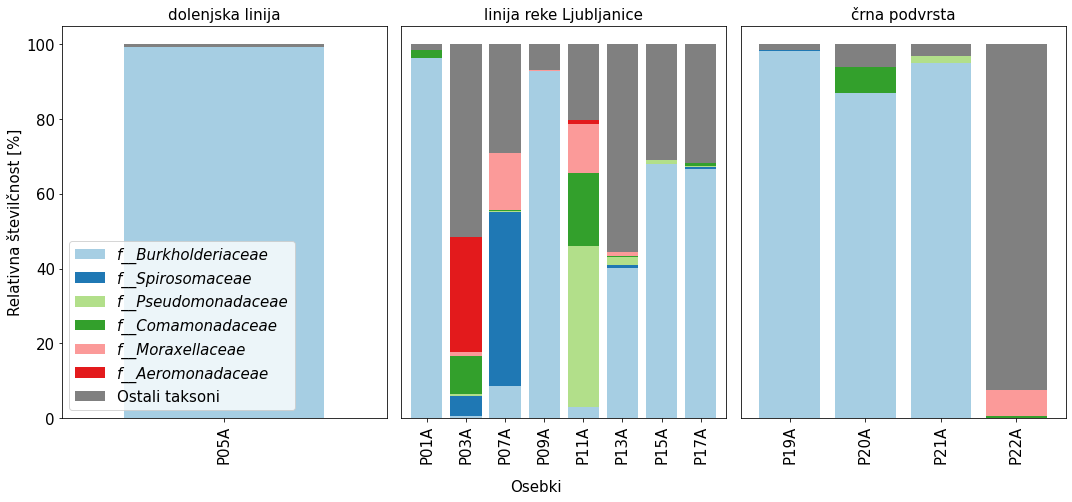

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

max_count = 7
groups = ['dolenjska linija', 'linija reke Ljubljanice', 'črna podvrsta']
kwargs = dict(level=5, count=max_count, sort_by_mean2=False)

colors = list(plt.cm.Paired.colors)
colors[max_count-1] = 'gray'

for i, group in enumerate(groups):
    ax = axes[i]
    dokdo.taxa_abundance_bar_plot(
        taxa_bar_plot,
        ax=ax,
        colors=colors,
        include_samples={'population': [group]},
        legend_short=True,
        legend=True if i == 0 else False,
        **kwargs # da razbije dictionary se uporabi **
    )
    if i != 0:
        ax.get_yaxis().set_visible(False)
    ax.set_title(group)

# custom properties    
fig.supxlabel('Osebki', fontsize = 15)
axes[0].set_ylabel('Relativna številčnost [%]')

        
h, l = axes[0].get_legend_handles_labels()
l[-1] = 'Ostali taksoni'

legend = axes[0].legend(h, l, prop={'size': 15, 'style': 'italic'})
legend.get_texts()[-1].set_style('normal')

for idx, ax in enumerate(axes):
    ax.tick_params(axis='x', labelrotation = 90, labelsize=15)  # reset rotation
    ax.tick_params(axis='y', labelsize=15)
    ax.yaxis.label.set_size(15)
    ax.title.set_size(15)
    
plt.tight_layout()
plt.savefig('./results/proteus_all_populations_bacteria.png')

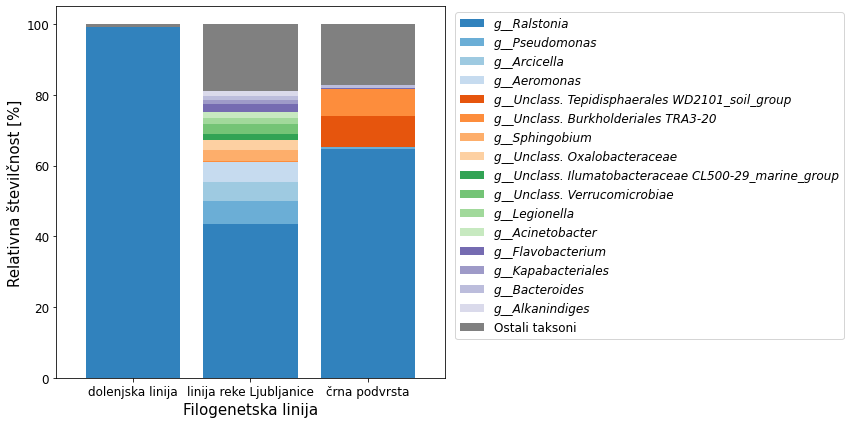

In [32]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [9, 0]})

max_count = 17
kwargs = dict(level=6, count=max_count, sort_by_mean2=False)

colors = list(plt.cm.tab20c.colors)
colors[max_count-1] = 'gray'

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    group='population',
    group_order=['dolenjska linija', 'linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    legend=False,
    colors=colors,
    **kwargs
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    group='population',
    group_order=['dolenjska linija', 'linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    legend_short=True,
    colors=colors,
    **kwargs
)

# custom properties    
ax1.set_xlabel('Filogenetska linija', fontsize = 15)
ax1.set_ylabel('Relativna številčnost [%]')

handles, labels = ax2.get_legend_handles_labels()
labels[-1] = 'Ostali taksoni'

ax2.clear()
legend = ax2.legend(handles, labels, prop={'size': 12, 'style': 'italic'})
legend.get_texts()[-1].set_style('normal')
ax2.axis('off')

ax1.tick_params(labelrotation = 0, labelsize=12)  # reset rotation
ax1.yaxis.label.set_size(15)

plt.tight_layout()
plt.savefig('./results/populations_together_ba.png')

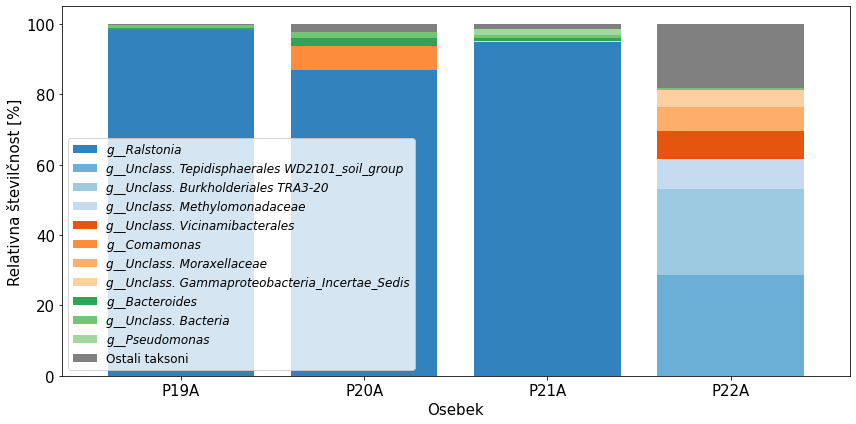

In [33]:
max_count = 12

kwargs = dict(
    include_samples={'population': ['črna podvrsta']},
    label_columns=['sample-id'],
    level=6,
    count=max_count,
)

colors = list(plt.cm.tab20c.colors)
colors[max_count-1] = 'gray'

fig, ax = plt.subplots(figsize=(12, 6))

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    figsize=(12, 6),
    colors=colors,
    legend_short=True,
    ax=ax,
    **kwargs
)

handles, labels = ax.get_legend_handles_labels()
labels[-1] = 'Ostali taksoni'

ax.tick_params(labelrotation = 0, labelsize=15) 
ax.yaxis.label.set_size(15)
ax.xaxis.label.set_size(15)
legend = ax.legend(handles, labels, prop={'size': 12,'style': 'italic'})
legend.get_texts()[-1].set_style('normal')

ax.set_xlabel('Osebek', fontsize = 15)
ax.set_ylabel('Relativna številčnost [%]')

plt.tight_layout()
plt.savefig('./results/crni_primerjava10najpogostejsih_ba.png')

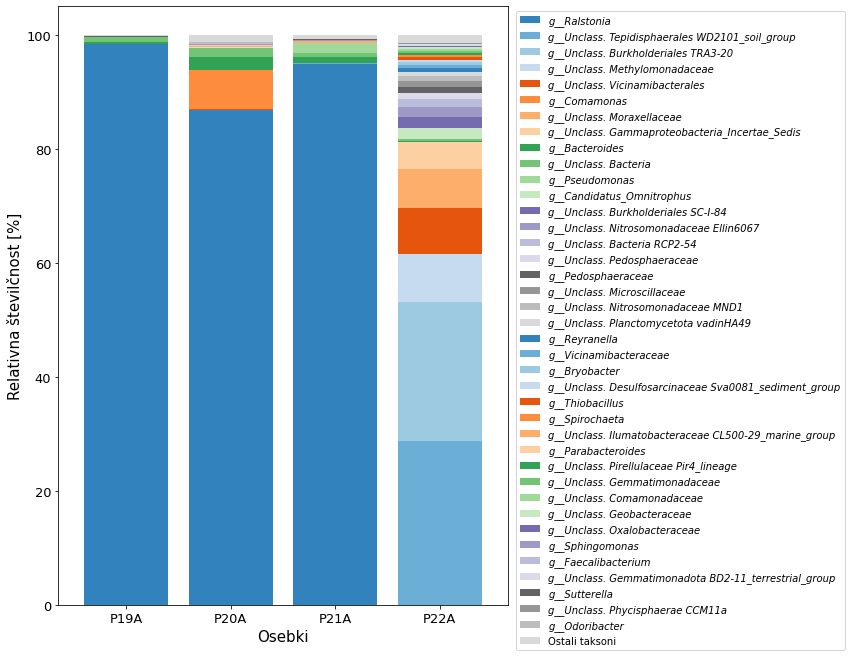

In [48]:
max_count = 40
colors = list(plt.cm.tab20c.colors)
#colors[max_count-1] = 'gray'

kwargs = dict(
    include_samples={'population': ['črna podvrsta']},
    label_columns=['sample-id'],
    level=6,
    count=max_count,
)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [3, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    figsize=(12, 6),
    colors=colors,
    legend=False,
    ax=ax1,
    **kwargs
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    figsize=(12, 6),
    colors=colors,
    legend_short=True,
    ax=ax2,
    **kwargs
)

# custom properties    
ax1.set_xlabel('Osebki', fontsize = 15)
ax1.set_ylabel('Relativna številčnost [%]')

handles, labels = ax2.get_legend_handles_labels()
labels[-1] = 'Ostali taksoni'

ax2.clear()
legend = ax2.legend(handles, labels, prop={'size': 10, 'style': 'italic'})
legend.get_texts()[-1].set_style('normal')
ax2.axis('off')

ax1.tick_params(labelrotation = 0, labelsize=13)  # reset rotation
ax1.yaxis.label.set_size(15)

plt.tight_layout()
plt.savefig('./results/crni_40.png')

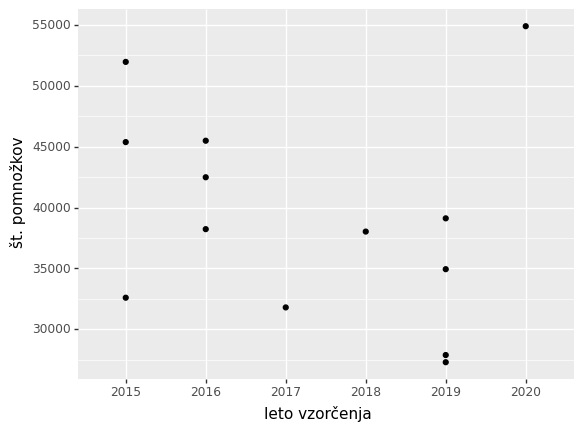

<ggplot: (8774301461095)>

In [52]:
# quick viz - reads per year
# add reads column
mtdt_df = sample_metadata.to_dataframe()
mtdt_df = pd.DataFrame(mtdt_df)
reads = [32593, 51974, 45495, 31795, 34937, 38028, 27291, 27881, 39116, 38227, 42491,45382, 54906]
mtdt_df['reads'] = reads

# plot no of reads per year
(p9.ggplot(data=mtdt_df.reset_index(),
           mapping=p9.aes(x='year', y='reads'))
+ p9.geom_point()
+ p9.labels.xlab('leto vzorčenja')
+ p9.labels.ylab('št. pomnožkov')
)


